In [80]:
%matplotlib inline
from pylab import *
import numpy as np

# method to generate a sample space to simulate
# k is number of packets able to be serviced
# la is the rate of incoming packets
# mu is the rate at which the server can process
# sample size of packets to test
def generate_samples(k, la, mu, samp):
    # rho is a constant used in calculating M/M/1/k probabilities
    rho = la/mu
    
    # a is interarrival times based on rate of arrival (la)
    # s is interdeparture times based on rate of service (mu)
    a = []
    s = []
    # provides a sample of interval times
    # times are according to a Poisson Process
    for i in range(0,samp):
        a.append(exponential(1/la))
        s.append(exponential(1/mu))

    # plots a histogram to compare the two intervals
    t = np.arange(0,2,0.1)
    f, (ax1, ax2) = subplots(1, 2, sharey=True)
    ax1.set_title("Interarrival Time of Packets")
    ax1.set_ylabel("Number of packets")
    ax1.set_xlabel("Time(s)")
    ax2.set_title("Interservice Time of Packets")
    ax2.set_ylabel("Number of packets")
    ax2.set_xlabel("Time(s)")
    ax1.hist(a,t,label="Arrivals")
    ax2.hist(s,t,label="Served")
    show()
    """
    figure(2)
    hist(a,t,label="Arrivals")
    hist(s,t,label="Served")
    title("Overlay of Interval Plots")
    ylabel("Number of packets")
    xlabel("Time(s)")
    legend(loc="upper right")
    """

    # calculates the expected blocking probability
    pb = np.power(rho,k) * ((1-rho)/(1-np.power(rho, k+1)))
    print("Expected blocking probability: ", pb)
    # shows the average interval times
    print("\nExpected average arrival interval: ", 1/la)
    print("Simulated average arrival interval: ", average(a))
    print("\nExpected average service interval: ", 1/mu)
    print("Simulated average service interval: ", average(s))

    return a, s

# method to perform simulation
def simulate(maxbuf, a, s, phi):
    samp = len(a)
    # set initial time
    t = 0
    # set empty buffer
    buf1 = 0
    buf2 = 0
    # server is initially idle
    idle1 = True
    idle2 = True
    # i,j are indexes for arrival and service
    # time intervals respectively
    i = 0
    j = 0
    # drop counts packets dropped when buf is full
    drop1 = 0
    drop2 = 0

    # loop over the entire sample space
    while i < samp:
        if random() <= phi:
            # idle server state
            if idle1:
                t += a[i]
                i += 1
                idle1 = False

            # active server state
            if not idle1:
                # checks if the server has processed a packet
                if s[j] <= a[i]:
                    t += s[j]
                    a[i] -= s[j]
                    # process next packet in buffer
                    if buf1 > 0:
                        buf1 -= 1
                    # if nothing in buffer server is idle
                    else:
                        idle1 = True
                    j += 1

                # checks if a packet has arrived before
                # the server has finished processing a packet
                if s[j] > a[i]:
                    t += a[i]
                    s[j] -= a[i]
                    # if buffer is full then a packet is dropped
                    if buf1 is maxbuf:
                        drop1 += 1
                    # packet to buffer
                    else:
                        buf1 += 1
                    i += 1
                    
        else:
            # idle server state
            if idle2:
                t += a[i]
                i += 1
                idle2 = False

            # active server state
            if not idle2:
                # checks if the server has processed a packet
                if s[j] <= a[i]:
                    t += s[j]
                    a[i] -= s[j]
                    # process next packet in buffer
                    if buf2 > 0:
                        buf2 -= 1
                    # if nothing in buffer server is idle
                    else:
                        idle2 = True
                    j += 1

                # checks if a packet has arrived before
                # the server has finished processing a packet
                if s[j] > a[i]:
                    t += a[i]
                    s[j] -= a[i]
                    # if buffer is full then a packet is dropped
                    if buf2 is maxbuf:
                        drop2 += 1
                    # packet to buffer
                    else:
                        buf2 += 1
                    i += 1
                    

    drop = drop1 + drop2
    print("\n{1} packets processed in ~{0:0.3f}sec".format(t,i))
    print("Total packets dropped: ", drop)
    print("Simulated blocking probability: ", drop/i)

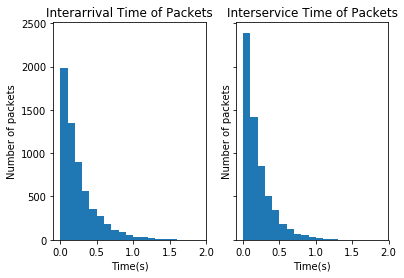

Expected blocking probability:  0.0888194986556

Expected average arrival interval:  0.25
Simulated average arrival interval:  0.251630733529

Expected average service interval:  0.2
Simulated average service interval:  0.199488898131

6000 packets processed in ~1509.784sec
Total packets dropped:  300
Simulated blocking probability:  0.05


In [81]:
a, s = generate_samples(5, 4, 5, 6000)
simulate(5, a, s, 0.5)